# Ground truth recordings for validation of spike sorting algorithms


Spampinato from Institut de la Vision have publish data from mice retina recorded with from dense array.
The data contain one ground truth to benchmark spike sorting tools.

Here the official publication of this open dataset:
https://zenodo.org/record/1205233#.W9mq1HWLTIF

Pierre Yger publish its tools (spyking circus) here tested with this datasets:
https://elifesciences.org/articles/34518


Here an example on one file from this dataset to test tridesclous.

The file is **20160426_patch3**








In [1]:
# suposing the datset is downloaded here
basedir = '/media/samuel/SamCNRS/DataSpikeSorting/pierre/zenodo/20160426_patch3/'
filename = basedir + 'patch_3.raw'


In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import tridesclous as tdc
from tridesclous import DataIO, CatalogueConstructor, Peeler
import os, shutil

## create a DataIO (and remove if already exists)

In [4]:
dirname = basedir + 'tdc_20160426_patch3'

if os.path.exists(dirname):
    #remove is already exists
    shutil.rmtree(dirname)
    
dataio = DataIO(dirname=dirname)

# feed DataIO with one file
dataio.set_data_source(type='RawData', filenames=[filename], 
                    sample_rate=20000., dtype='uint16', total_channel=256, offset=1867,
                    bit_to_microVolt=0.1042)
print(dataio)

# set the probe file
dataio.set_probe_file('GT_252.prb')

DataIO <id: 140307392066056> 
  workdir: /media/samuel/SamCNRS/DataSpikeSorting/pierre/zenodo/20160426_patch3/tdc_20160426_patch3
  sample_rate: 20000.0
  total_channel: 256
  channel_groups: 0 [ch0 ch1 ch2 ch3 ... ch252 ch253 ch254 ch255]
  nb_segment: 1
  length: 3600000
  durations: 180.0 s.


# CatalogueConstructor

Run all chain in one shot.

Note:
  * The original signal provide by autors is already filtered.
  * This is pretty slow on my laptop (500s.) but on recent machine with nivdia GPU it should more fatser (x2).
  * That this part can be done only on some minut of signal and not the entire dataset.


In [5]:
cc = CatalogueConstructor(dataio=dataio, chan_grp=1)

fullchain_kargs = {
    'duration' : 180.,
    'preprocessor' : {
        'highpass_freq' : None,
        'lowpass_freq' : None,
        'smooth_size' : 0,
        'chunksize' : 1024,
        'lostfront_chunksize' : 128,
        'signalpreprocessor_engine' : 'opencl',
        'common_ref_removal':True,
    },
    'peak_detector' : {
        'peakdetector_engine' : 'opencl',
        'peak_sign' : '-',
        'relative_threshold' : 5.5,
        'peak_span' : 0.0002,
    },
    'noise_snippet' : {
        'nb_snippet' : 300,
    },
    'extract_waveforms' : {
        'n_left' : -45,
        'n_right' : 60,
        'mode' : 'rand',
        'nb_max' : 20000,
        'align_waveform' : False,
    },
    'clean_waveforms' : {
        'alien_value_threshold' : 100.,
    },
  }
feat_method = 'peak_max'
feat_kargs = {}
clust_method = 'sawchaincut'
clust_kargs = {'kde_bandwith': 1.}
      
tdc.apply_all_catalogue_steps(cc, fullchain_kargs, 
        feat_method, feat_kargs,clust_method, clust_kargs)

print(cc)

estimate_signals_noise 8.593001977002132
run_signalprocessor 113.41388248599833
extract_some_waveforms 168.17321472299955
clean_waveforms 93.44064283400076
extract_some_noise 5.749768894002045
project 120.34225368300031
order_clusters waveforms_rms
find_clusters 30.770147544000793
CatalogueConstructor
  chan_grp 1 - ch0 ch1 ch2 ... ch252 ch253
  nb_peak_by_segment: 25846
  some_waveforms.shape: (13938, 105, 252)
  some_features.shape: (13938, 252)
  cluster_labels [-11  -1   0   1   2   3   4   5   6]



## Noise measurement

In [8]:
dataio = DataIO(dirname=dirname)
tdc.summary_noise(dataio=dataio, chan_grp=1)


Noise mesured with mesured with MAD (=robust STD)
  Channel group 1
  Nb_channel:  252
  Noise range: 4.87 - 35.61 μV
  By channel noise: [18.9 14.0 10.5 6.9 ... 9.5 5.8 5.6 12.4] μV
  Average noise along channel: 13.587339401245117  μV
  Threshold:  5.5 *MAD = 74.73036670684814 μV



## Inspect waveform quality at catalogue level

This must be done carrfully with CatalogueWindow.
Not shown here.


Cluster 0
Max on channel (abs): 178
Max on channel (local to group): 176
Peak amplitude MAD: -7.548345565795898
Peak amplitude (µV): -79.2962010556805




<IPython.core.display.Javascript object>


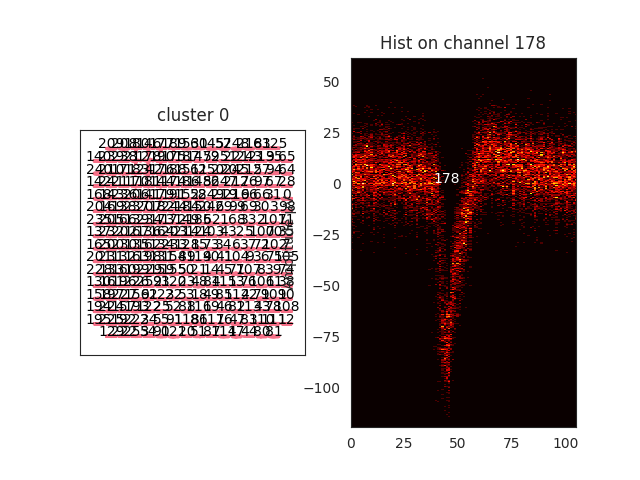

In [7]:
tdc.summary_cataltdc.summary_after_peeler_clusters(dataio, label=0)
ogue_clusters(dataio=dataio, chan_grp=1, label=0)


Cluster 1
Max on channel (abs): 189
Max on channel (local to group): 187
Peak amplitude MAD: -7.068875789642334
Peak amplitude (µV): -69.34509881131565




<IPython.core.display.Javascript object>


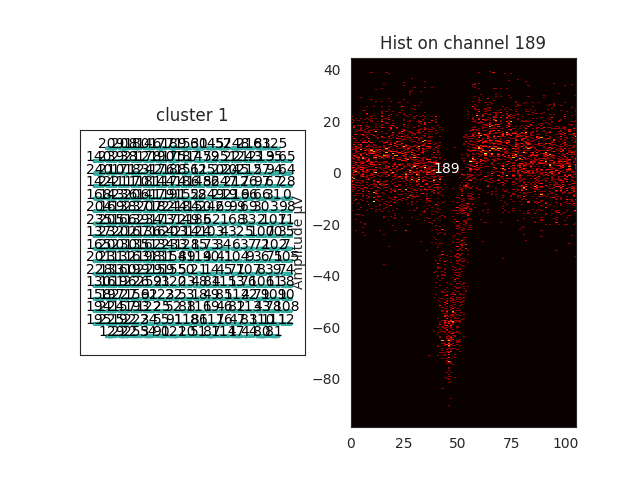

In [11]:
tdc.summary_catalogue_clusters(dataio=dataio, chan_grp=1, label=1)


Cluster 2
Max on channel (abs): 212
Max on channel (local to group): 210
Peak amplitude MAD: -15.27180290222168
Peak amplitude (µV): -95.55139787718252




<IPython.core.display.Javascript object>


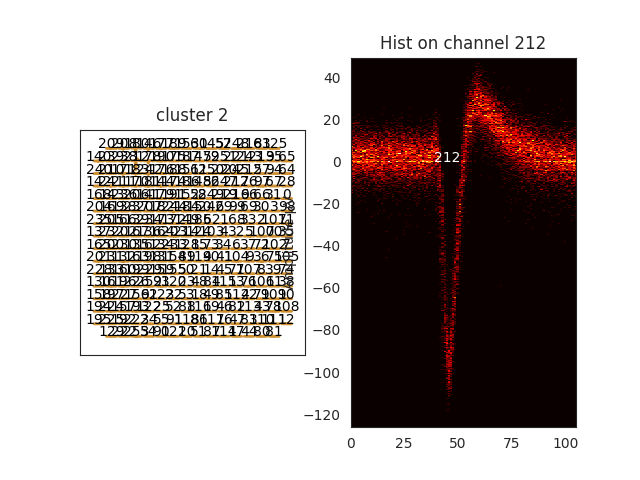

In [12]:
tdc.summary_catalogue_clusters(dataio=dataio, chan_grp=1, label=2)

## construct catalogue

In [10]:
cc.make_catalogue_for_peeler()

make_catalogue 27.622185938002076


## apply peeler

This is the real spike sorting: find spike that correcpond to catalogue templates.

Note that with high channel count (252) with have to use the **sparse template** option and opencl.

On my laptop it take more or less the same time duration (180s.) than the original file. 

In [13]:
initial_catalogue = dataio.load_catalogue(chan_grp=1)

peeler = Peeler(dataio)
peeler.change_params(catalogue=initial_catalogue,
                    use_sparse_template=True,
                    sparse_threshold_mad=1.5,
                    use_opencl_with_sparse=True,)
peeler.run(duration=None, progressbar=True)

  0%|          | 0/3515 [00:00<?, ?it/s]

average sparseness for templates 0.023809523809523808


100%|██████████| 3515/3515 [03:33<00:00, 16.47it/s]


# final inspection of cells

<IPython.core.display.Javascript object>


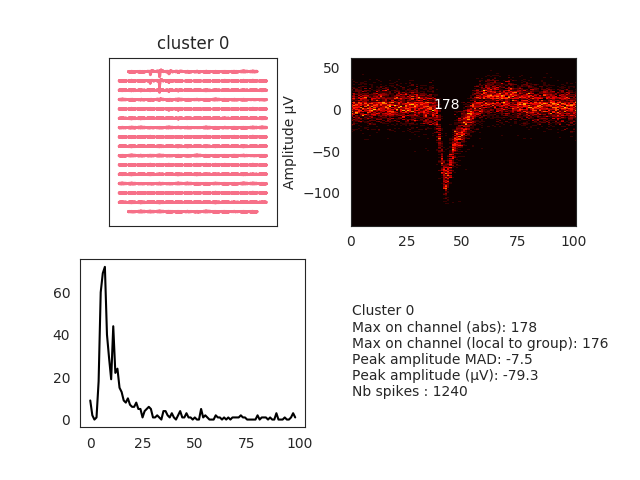


Cluster 0
Max on channel (abs): 178
Max on channel (local to group): 176
Peak amplitude MAD: -7.5
Peak amplitude (µV): -79.3
Nb spikes : 1240




In [5]:
tdc.summary_after_peeler_clusters(dataio=dataio, chan_grp=1, label=0, show_channels=False)


<IPython.core.display.Javascript object>


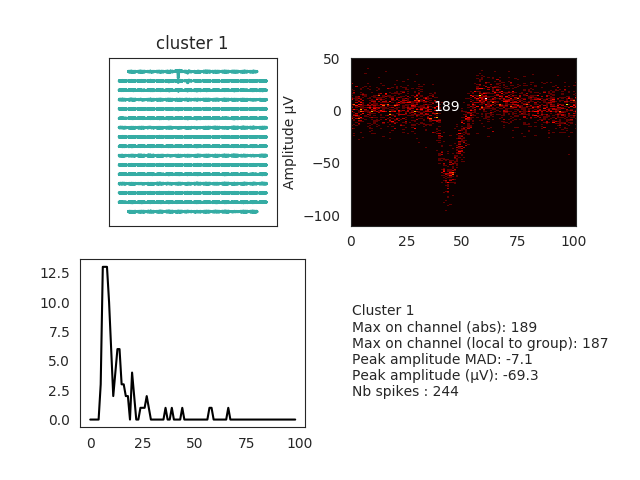


Cluster 1
Max on channel (abs): 189
Max on channel (local to group): 187
Peak amplitude MAD: -7.1
Peak amplitude (µV): -69.3
Nb spikes : 244




In [6]:
tdc.summary_after_peeler_clusters(dataio, label=1, show_channels=False)

<IPython.core.display.Javascript object>


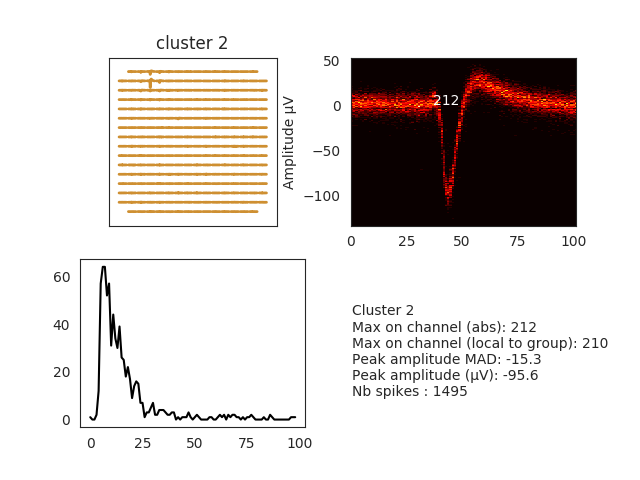


Cluster 2
Max on channel (abs): 212
Max on channel (local to group): 210
Peak amplitude MAD: -15.3
Peak amplitude (µV): -95.6
Nb spikes : 1495




In [7]:
tdc.summary_after_peeler_clusters(dataio, label=2, show_channels=False)

<IPython.core.display.Javascript object>


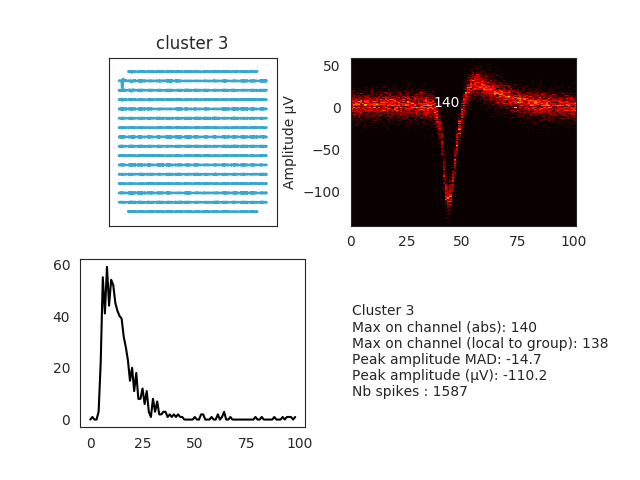


Cluster 3
Max on channel (abs): 140
Max on channel (local to group): 138
Peak amplitude MAD: -14.7
Peak amplitude (µV): -110.2
Nb spikes : 1587




In [8]:
tdc.summary_after_peeler_clusters(dataio, label=3, show_channels=False)

<IPython.core.display.Javascript object>


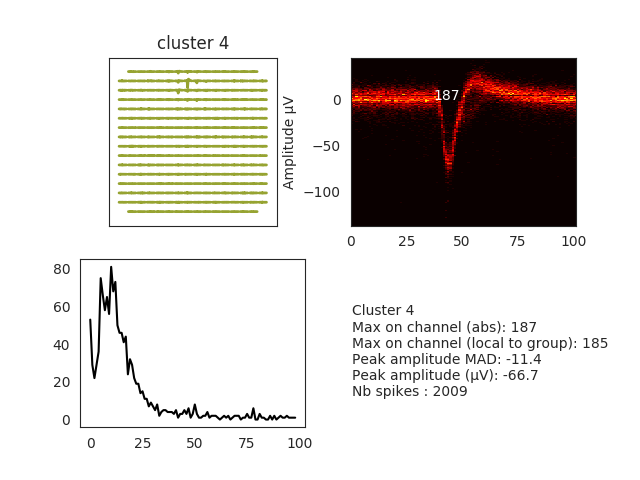


Cluster 4
Max on channel (abs): 187
Max on channel (local to group): 185
Peak amplitude MAD: -11.4
Peak amplitude (µV): -66.7
Nb spikes : 2009




In [9]:
tdc.summary_after_peeler_clusters(dataio, label=4, show_channels=False)

<IPython.core.display.Javascript object>


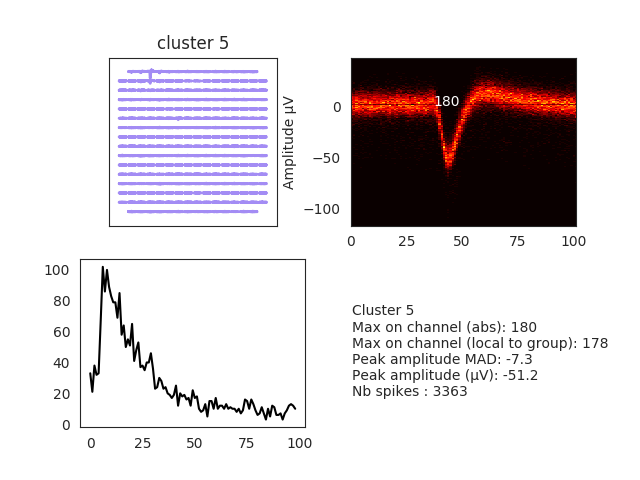


Cluster 5
Max on channel (abs): 180
Max on channel (local to group): 178
Peak amplitude MAD: -7.3
Peak amplitude (µV): -51.2
Nb spikes : 3363




In [10]:
tdc.summary_after_peeler_clusters(dataio, label=5, show_channels=False)

<IPython.core.display.Javascript object>


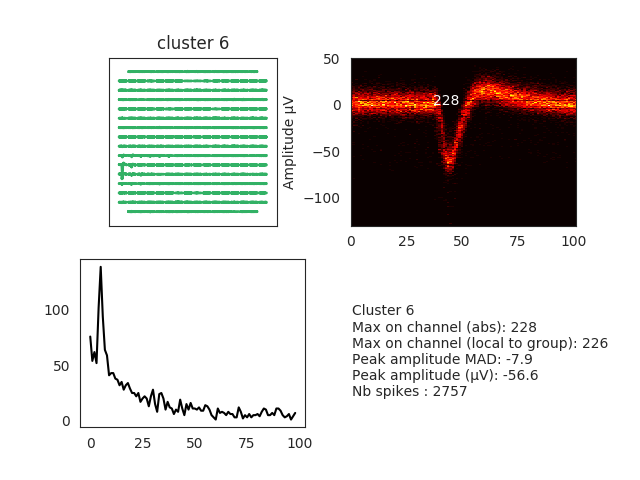


Cluster 6
Max on channel (abs): 228
Max on channel (local to group): 226
Peak amplitude MAD: -7.9
Peak amplitude (µV): -56.6
Nb spikes : 2757




In [11]:
tdc.summary_after_peeler_clusters(dataio, label=6, show_channels=False)